# **Deep Dream**

#Install

In [ ]:
!pip install pytube3

Install the dependencies needed to turn your video into digestible frames for deep dream and then redownload it at the end.



In [ ]:
from pytube import YouTube
import os
import shutil
import math
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from os.path import isfile, join
from google.colab import drive 

Install the dependencies for Google's Deep Dream.

In [ ]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

import tensorflow as tf

# Upload Video
Choose the video you want from youtube. Alternatively you can download a video to your computer and put the path in videopath.

In [ ]:
##To use a YouTube video:
#yt = YouTube('https://www.youtube.com/watch?v=oeLQI-EFff8') #paste any youtube link here
#print('Your video is titled "'+str(yt.title)+'". It is '+str(yt.length)+' seconds long.')
#stream = yt.streams.first()
#videopath = stream.download() 

#To use a local file on your machine:
from google.colab import files
videopath = files.upload() #choose the file you wish to upload when prompted
video = cv2.VideoCapture('search_original_trim_Trim (1).mp4') #rename according to what is displayed below

#NOTE:
#You may need to re-run this block with videopath commented out and the correct name for video

#Turn Video into Frames
Turn your video into frames that will be dreamified individually. Changing the frameRate changes the number of frames captured per second. Humans see around 24 frames per second but keep in mind that each frame takes about a minute to run.

In [ ]:
try: 
      
    # create a folder named data 
    if not os.path.exists('data'): 
        os.makedirs('data') 
  
# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of data') 

vidcap = video

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        if count < 10:
          name="./data/image00"+str(count)+".jpg"
        elif 10 <= count < 100:
          name="./data/image0"+str(count)+".jpg"
        elif 100<=count<1000:
          name="./data/image"+str(count)+".jpg"
        elif count > 1000:
          print('You have too many files. Try a shorter video or slower frame rate.')
        print ('Creating...' + name) 
        cv2.imwrite(name, image)     # save frame as JPG file
    return hasFrames
    
sec = 0
frameRate = 0.05 #//it will capture image every 0.05 seconds
fps = 1/frameRate
count=1 #number of frames
success = getFrame(sec)
while success: 
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

# Release all space and windows once done 
vidcap.release() 
cv2.destroyAllWindows() 
print('Estimated time to dreamify: '+str(count)+' minutes. (1 minute per frame)')

Creating..../data/image001.jpg
Creating..../data/image002.jpg
Creating..../data/image003.jpg
Creating..../data/image004.jpg
Creating..../data/image005.jpg
Creating..../data/image006.jpg
Creating..../data/image007.jpg
Creating..../data/image008.jpg
Creating..../data/image009.jpg
Creating..../data/image010.jpg
Creating..../data/image011.jpg
Creating..../data/image012.jpg
Creating..../data/image013.jpg
Creating..../data/image014.jpg
Creating..../data/image015.jpg
Creating..../data/image016.jpg
Creating..../data/image017.jpg
Creating..../data/image018.jpg
Creating..../data/image019.jpg
Creating..../data/image020.jpg
Creating..../data/image021.jpg
Creating..../data/image022.jpg
Creating..../data/image023.jpg
Creating..../data/image024.jpg
Creating..../data/image025.jpg
Creating..../data/image026.jpg
Creating..../data/image027.jpg
Creating..../data/image028.jpg
Creating..../data/image029.jpg
Creating..../data/image030.jpg
Creating..../data/image031.jpg
Creating..../data/image032.jpg
Creating

#Prepare to dream-ify

Use the pre-trained model Inception V3 to dreamify your image. You can customize which layers you activate. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Lower layers respond to lower level features (textures, shapes) while higher layers respond to higher level features (eyes, faces). 

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

This function will run the simplest (and fastest) form of deep dream. For a better quality photo with different scaling of patterns, try my other file, deepdreamoctave.

In [ ]:
def run_deep_dream_simple(img, steps=50, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

#for n in range(-2, 3):
#  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

#  img = tf.image.resize(img, new_shape).numpy()

#  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

#display.clear_output(wait=True)
#img = tf.image.resize(img, base_shape)
#img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
#show(img)

#end = time.time()
#end-start

In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

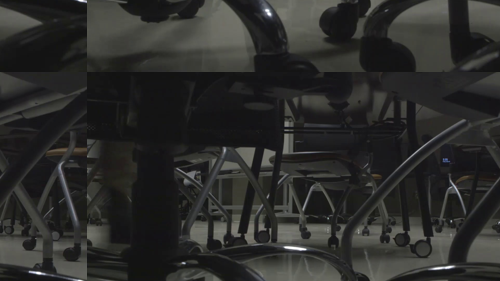

In [ ]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=10, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=2):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

# Test the first image
These functions download the image so it can be processed by deep dream. Use the show function to show the first frame of your video as a test.

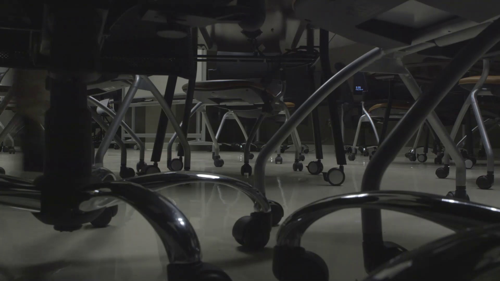

In [ ]:
# Download an image and read it into a NumPy array.
def download(image_path, max_dim=None):
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

  # Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download('./data/image002.jpg', max_dim=500)
show(original_img)

#Dreamify Each Frame
Now we dreamify every frame of the video. WARNING: this cell takes a very long time to run, usually around a minute for each frame. Running this takes lots of memory (RAM) on your machine.

In [ ]:
deepdream = DeepDream(dream_model)
for i in range(1,count):
  if i<10:
    imagepath= './data/image00' + str(i) + '.jpg'
  elif 10<=i<100:
    imagepath='./data/image0'+str(i)+'.jpg'
  elif i>=100:
    imagepath='./data/image'+str(i)+'.jpg'
  image = download(imagepath, max_dim=500)
  print('Running deep dream with octaves on '+ imagepath)
  dream_img = run_deep_dream_with_octaves(img=image, step_size=0.01) #change the step size for different effects
  #display.clear_output(wait=True)
  print('Resizing image' + imagepath)
  dream_image = tf.image.resize(dream_img, base_shape)
  print('Converting image' + imagepath)
  dreamimage=tf.cast(dream_img, tf.float32)/255.0
  dream_image = tf.image.convert_image_dtype(dreamimage, dtype=tf.uint8)
  print('Displaying image'+imagepath)
  show(img)
  print ('Writing to folder' + imagepath) 
  cv2.imwrite(imagepath, np.array(dream_img))
  print('Moving on to next image')


Output hidden; open in https://colab.research.google.com to view.

#Compile Frames into Video
Finally, turn your frames back into a video! Change the pathOut to name your video file.

In [ ]:
pathIn = './data/'
pathOut = 'dreamifiedsearch_part2.avi'


frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
files.sort()
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    #inserting the frames into an image array
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

#Download your file.
Run this block to download your file! Congrats!

In [ ]:
import io
from google.colab import files
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./') if isfile(join('./', f))]

for file in onlyfiles:
  if file.startswith(pathOut):
    print(file)
    files.download(file)

dreamifiedsearch_part2.avi


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

I recommend clearing your data file before moving onto a different video. DO NOT RUN IF YOU HAVENT SAVED YOUR VIDEO. This will delete all of the original or dreamified frames (depending on whether you've run deepdream on them or not).

In [ ]:
!rm -rf data